<a href="https://colab.research.google.com/github/davidmakovoz/machine-learning/blob/master/BertEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 8.0MB/s 


In [0]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#ffffff'),
  ('background-color', '#000000')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '20px'),
    ('text-align', 'center'),
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


In [0]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

<img src="http://drive.google.com/uc?export=view&id=1bhjSBpVLmh3h___dXPbnW1pfed0yQe4z" alt="Drawing" style="width: 800px;" />

## Load Tokenizer for BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters

In [5]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 673670.32B/s]


In [6]:
len(tokenizer.vocab.keys())

30522

### Infrequent words not found in the vocabulary are broken into pieces

In [7]:
words = "embeddings beddings breading  dreading heading hedding kaeding reading redding shedding shredding spreading steading tedding threading treading wedding yedding"

for word in words.split():
    print('{:<12} {:}    {:}'.format(word, word in tokenizer.vocab.keys(), tokenizer.tokenize(word)))



embeddings   False    ['em', '##bed', '##ding', '##s']
beddings     False    ['bed', '##ding', '##s']
breading     False    ['bread', '##ing']
dreading     False    ['dread', '##ing']
heading      True    ['heading']
hedding      False    ['he', '##dding']
kaeding      False    ['ka', '##eding']
reading      True    ['reading']
redding      True    ['redding']
shedding     False    ['shed', '##ding']
shredding    False    ['sh', '##red', '##ding']
spreading    True    ['spreading']
steading     False    ['ste', '##ading']
tedding      False    ['ted', '##ding']
threading    False    ['thread', '##ing']
treading     False    ['tread', '##ing']
wedding      True    ['wedding']
yedding      False    ['ye', '##dding']


In [8]:
'##dding' in tokenizer.vocab.keys()

True

## Load BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters

In [9]:
model = BertModel.from_pretrained('bert-base-uncased')

100%|██████████| 407873900/407873900 [00:15<00:00, 26540778.44B/s]


In [10]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

## bert_embedding returns the bert embeddins for the words in *text* for the specified *layer_number*. Among other things it:
- adds special tokens [CLS] and [SEP]
- adds positional layer
- adds sentence layer

<img src="http://drive.google.com/uc?export=view&id=1xtEJ6tCPUr_cBDPoM8RaRjC9iGG8j2oA" alt="Drawing" style="width: 800px;" />

In [0]:
def bert_embedding(text, bert_model, bert_tokenizer, layer_number = 0, verbose = False):
    
    # Add the special tokens.
    marked_text = "[CLS] " + text + " [SEP]"
    
    #the default is the last layer: 0-1 = -1
    layer_number -= 1

    # Split the sentence into tokens.
    tokenized_text = bert_tokenizer.tokenize(marked_text)
    if verbose:
        print (tokenized_text)

    # Map the token strings to their vocabulary indicies.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)   
    
    # Mark each of the  tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)
    
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
#torch.no_grad deactivates the gradient calculations, saves memory, and speeds up computation 
#(we don’t need gradients or backpropagation since we’re just running a forward pass).
# Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = bert_model(tokens_tensor, segments_tensors)
        
    return encoded_layers[layer_number][0][:]

## Experiment with the sentences:

<font size="5">*'i love the beautiful **spring**, because the flowers are blossoming in the **spring**.'*</font> 

<font size="5">*'when it takes a load, the torsion **spring** rotates on its axis.'*</font>

In [0]:
text1 = 'i love the beautiful spring, because the flowers are blossoming in the spring.'
text2 = 'when it takes a load, the torsion spring rotates on its axis.'

### Output tokenization

In [13]:
embed1 = bert_embedding(text1, model, tokenizer, verbose=True)

['[CLS]', 'i', 'love', 'the', 'beautiful', 'spring', ',', 'because', 'the', 'flowers', 'are', 'blossom', '##ing', 'in', 'the', 'spring', '.', '[SEP]']


In [14]:
embed2 = bert_embedding(text2, model, tokenizer, verbose=True)

['[CLS]', 'when', 'it', 'takes', 'a', 'load', ',', 'the', 'tor', '##sion', 'spring', 'rotate', '##s', 'on', 'its', 'axis', '.', '[SEP]']


In [0]:
spring1 = embed1[5]
spring2 = embed1[-3]
spring3 = embed2[10]
because = embed1[7]

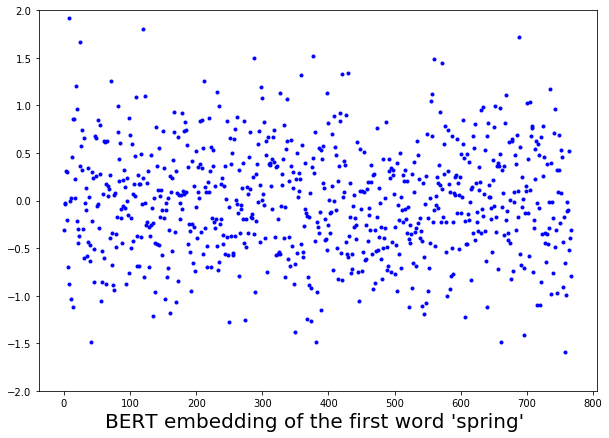

In [18]:
plt.figure(figsize=(10,7))
plt.plot(spring1, 'b.')
plt.xlabel("BERT embedding of the first word 'spring' ",  fontsize = 20)
plt.ylim(-2,2)
plt.show()

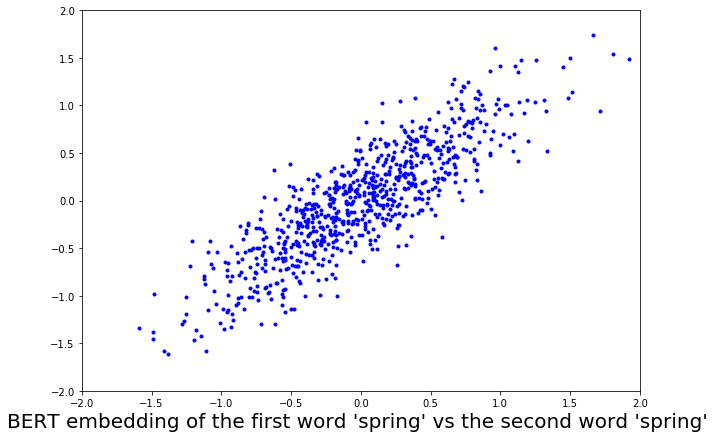

In [19]:
plt.figure(figsize=(10,7))
plt.plot(spring1,spring2, 'b.')
plt.xlabel("BERT embedding of the first word 'spring' vs the second word 'spring' ",  fontsize = 20)
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.show()

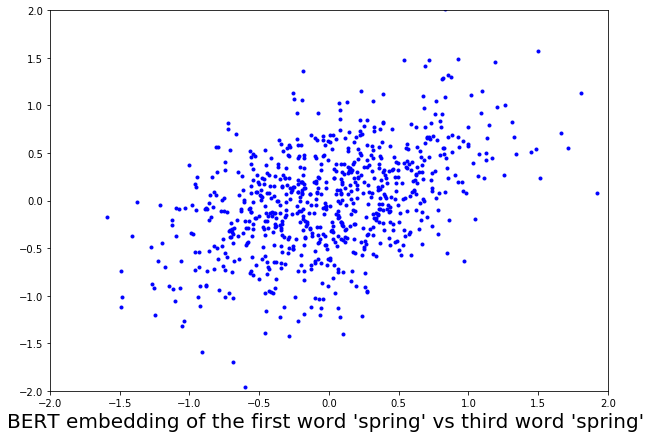

In [20]:
plt.figure(figsize=(10,7))
plt.plot(spring1,spring3, 'b.')
plt.xlabel("BERT embedding of the first word 'spring' vs third word 'spring' ",  fontsize = 20)
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.show()

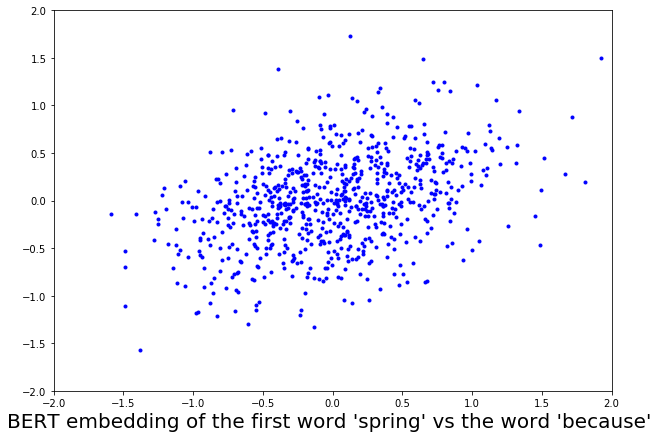

In [21]:
plt.figure(figsize=(10,7))
plt.plot(spring1,because, 'b.')
plt.xlabel("BERT embedding of the first word 'spring' vs the word 'because' ",  fontsize = 20)
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.show()

### Distance between 
- spring1 and spring2 $\approx 0.14$
- spring1 and because $\approx 0.59$
- spring1 and spring3 $\approx 0.51$

In [22]:
print(distance(spring1, spring2).tolist())
print(distance(spring1, because).tolist())
print(distance(spring1, spring3).tolist())

0.1410624384880066
0.5851813554763794
0.5119153261184692


# SYNSETS

In [0]:
import ipywidgets as widgets
from ipywidgets import interact

In [0]:
filename  = './sample_data/spring_synsets.csv'
df_spring = pd.read_csv(filename, encoding='utf-8')

In [0]:
meanings = df_spring.meaning.unique()
synsets = df_spring.synset.unique()

In [0]:
pd.set_option('display.max_colwidth', -1) 

In [29]:
@interact
def view_synsets(meaning = meanings):
    return df_spring[df_spring.meaning==meaning] 

interactive(children=(Dropdown(description='meaning', options=('season, n', 'season, a', 'water source', 'meta…

In [49]:
counts= df_spring.synset.value_counts()
df_synsets = pd.DataFrame(list(zip(synsets,meanings,counts)),
             columns = ['synset', 'meaning', 'counts'])
df_synsets.style.set_table_styles(styles)

,synset,meaning,counts
0,1,"season, n",20
1,2,"season, a",16
2,3,water source,12
3,4,metal thingy,10
4,5,"jump,v",10
5,6,political,7


## Words *spring* with the same meaning should have their embedding vectors closer to each other than to words with a different meaning

In [0]:
spring_embeddings = [bert_embedding(text, model, tokenizer, verbose=False) for text in df_spring.text.to_list()]

In [0]:
#to find the index of the key_word in the tokenized string
def bert_key_word_index(text, bert_tokenizer, key_word, verbose = False):
    # Add the special tokens.
    marked_text = "[CLS] " + text + " [SEP]"

    # Split the sentence into tokens.
    tokenized_text = bert_tokenizer.tokenize(marked_text)
    if verbose:
        print (tokenized_text)
    return tokenized_text.index(key_word)

In [0]:
spring_S= [(i,bert_key_word_index(s, tokenizer, 'spring')) for i,s in enumerate(df_spring.text.to_list())]

In [0]:
spring_distances = []
for i in range(len(spring_S)):
    for j in range(i+1,len(spring_S)):
        k1 = spring_S[i][0]
        i1 = spring_S[i][1]
        k2 = spring_S[j][0]
        i2 = spring_S[j][1] 
        dist = distance(spring_embeddings[k1][i1],spring_embeddings[k2][i2]).tolist()
        #print(dist)
        spring_distances.append((k1,k2,dist))

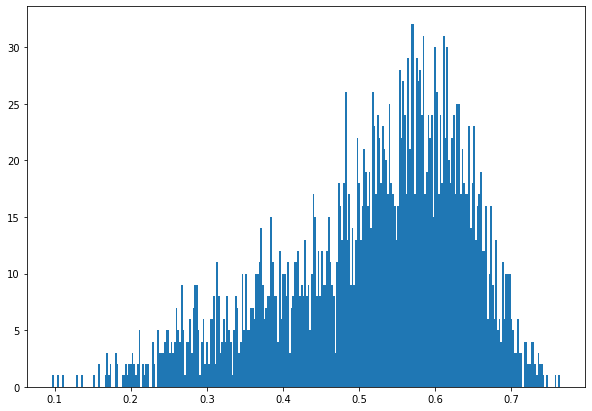

In [50]:
plt.figure(figsize=(10,7))
out = plt.hist([d[2] for d in spring_distances], bins = 300)

In [0]:
records = [(df_spring.text.to_list()[d[0]], df_spring.text.to_list()[d[1]], 
            df_spring.synset.to_list()[d[0]], df_spring.synset.to_list()[d[1]], d[2]) for d in spring_distances]
df_dist = pd.DataFrame.from_records(records, columns =['sentence1', 'sentence2', 'synset1','synset2' ,'distance'])
#df_dist.to_csv('.\data\spring_distances_pytorch_correct.csv')

In [45]:
range_slider = widgets.FloatRangeSlider(
    value=[0.0, 1.0],
    min=0.0, max=1.0, step=0.1,
    description='distance:',
    readout_format='.1f',
)
@interact
def view_synsets_distances(distance = range_slider, synset1 = synsets, synset2 = synsets):
    return df_dist[(df_dist.synset1==synset1) & (df_dist.synset2==synset2) &
                  (df_dist.distance > distance[0]) & (df_dist.distance < distance[1])] 

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='distance:', max=1.0, readout_format='.1f…

## For each word *'spring'* in one sentence find the sentence with the closest word *'spring'*
 <br>
<font size="4">
1. accuracy1 matching the synset of the matched sentences <br><br>
2. accuracy2 as accuracy1 but considers <i>'season, n'</i> a match of <i>'season, a'</i><br><br>
</font>

In [0]:
results = []
for layer_number in range(1,13,1):
    spring_embeddings = [bert_embedding(text, model, tokenizer, layer_number=layer_number) for text in df_spring.text.to_list()]
    spring_distances = []
    for i in range(len(spring_S)):
        for j in range(i+1,len(spring_S)):
            k1 = spring_S[i][0]
            i1 = spring_S[i][1]
            k2 = spring_S[j][0]
            i2 = spring_S[j][1] 
            dist = distance(spring_embeddings[k1][i1],spring_embeddings[k2][i2]).tolist()
            #print(dist)
            spring_distances.append((k1,k2,dist))

    match = dict.fromkeys(df_spring.index.to_list())
    min_dist = dict.fromkeys(df_spring.index.to_list(),10)
    for d in spring_distances:
        i1, i2 = d[:2]
        if min_dist[i1] > d[2]:
            min_dist[i1] = d[2]
            match[i1] = i2
        if min_dist[i2] > d[2]:
            min_dist[i2] = d[2]
            match[i2] = i1

    df_spring['text_match_index'] = list(match.values())
    df_spring['text_match_distance'] = list(min_dist.values())
    df_spring['text_match_synset'] = df_spring.iloc[list(match.values())]['synset'].to_list()
    df_spring['text_match'] = df_spring.iloc[list(match.values())]['text'].to_list()

    acc1 = sum(df_spring.synset == df_spring.text_match_synset)/df_spring.shape[0]

    # if we count spring noun and spring adjective as same
    acc2= sum(df_spring.apply(lambda x: 1  if x['synset'] == x['text_match_synset'] else( 1 if x['synset']*x['text_match_synset'] ==2
                    else 0), axis = 1))/df_spring.shape[0]   
    
    results.append((layer_number, round(acc1,2), round(acc2,2)))

## Find the layer with the best embedding

In [48]:
pd.DataFrame.from_records(results, columns = ['layer #', 'accuracy1', 'accuracy2']).style.set_table_styles(styles)

,layer #,accuracy1,accuracy2
0,1,0.57,0.71
1,2,0.8,0.87
2,3,0.81,0.89
3,4,0.84,0.88
4,5,0.88,0.93
5,6,0.91,0.93
6,7,0.92,0.93
7,8,0.93,0.95
8,9,0.93,0.95
9,10,0.93,0.96


### Layer 9 is the best

In [0]:
layer_number=9
spring_embeddings = [bert_embedding(text, model, tokenizer, layer_number=layer_number) for text in df_spring.text.to_list()]
spring_distances = []
for i in range(len(spring_S)):
    for j in range(i+1,len(spring_S)):
        k1 = spring_S[i][0]
        i1 = spring_S[i][1]
        k2 = spring_S[j][0]
        i2 = spring_S[j][1] 
        dist = distance(spring_embeddings[k1][i1],spring_embeddings[k2][i2]).tolist()
        #print(dist)
        spring_distances.append((k1,k2,dist))

match = dict.fromkeys(df_spring.index.to_list())
min_dist = dict.fromkeys(df_spring.index.to_list(),10)
for d in spring_distances:
    i1, i2 = d[:2]
    if min_dist[i1] > d[2]:
        min_dist[i1] = d[2]
        match[i1] = i2
    if min_dist[i2] > d[2]:
        min_dist[i2] = d[2]
        match[i2] = i1

df_spring['text_match_index'] = list(match.values())
df_spring['text_match_distance'] = list(min_dist.values())
df_spring['text_match_synset'] = df_spring.iloc[list(match.values())]['synset'].to_list()
df_spring['text_match'] = df_spring.iloc[list(match.values())]['text'].to_list()

acc1 = sum(df_spring.synset == df_spring.text_match_synset)/df_spring.shape[0]

# if we count spring noun and spring adjective as same
acc2= sum(df_spring.apply(lambda x: 1  if x['synset'] == x['text_match_synset'] else( 1 if x['synset']*x['text_match_synset'] ==2
                else 0), axis = 1))/df_spring.shape[0]   


In [53]:
df_spring

,text,synset,meaning,text_match_index,text_match_distance,text_match_synset,text_match
0,spring is around the corner.,1,"season, n",4,0.243190,1,in a few days the beautiful spring will be here.
1,the night air of spring was chilly in the mountains.,1,"season, n",6,0.185196,1,it seemed as if the spirit of spring had passed through the summer-house.
2,i don't know how the ranch ever saw a spring without your sunny smile.,1,"season, n",4,0.228063,1,in a few days the beautiful spring will be here.
3,it was spring and she was ravenously hungry.,1,"season, n",1,0.197071,1,the night air of spring was chilly in the mountains.
4,in a few days the beautiful spring will be here.,1,"season, n",7,0.165967,1,"i love the beautiful spring , because the budding trees and the blossoming flowers and the tender green leaves fill my heart with joy."
...,...,...,...,...,...,...,...
70,the downfall of the croatian spring marked the beginning of a period known as the croatian silence.,6,political,73,0.187741,6,"the damascus spring made a major impact across the arab world, and initially there was considerable optimism that it would lead to real change."
71,"during the beijing spring , the general public was allowed greater freedom to criticize the government than the chinese people had previously been allowed under the government of the people's republic of china.",6,political,72,0.137701,6,the seoul spring was a period of democratization in south korea from 26 october 1979 to 17 may 1980.
72,the seoul spring was a period of democratization in south korea from 26 october 1979 to 17 may 1980.,6,political,71,0.137701,6,"during the beijing spring , the general public was allowed greater freedom to criticize the government than the chinese people had previously been allowed under the government of the people's republic of china."
73,"the damascus spring made a major impact across the arab world, and initially there was considerable optimism that it would lead to real change.",6,political,72,0.174569,6,the seoul spring was a period of democratization in south korea from 26 october 1979 to 17 may 1980.
